In [182]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
import astropy.constants as const

import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
fs= 14
matplotlib.rcParams['font.size']=fs

%matplotlib notebook

In [183]:
z = 0.0213

In [184]:
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
D = cosmo.luminosity_distance([0.0213])[0].value * 1e+6 # in pc
D_cm = D * const.pc.cgs.value

In [185]:
nu1 = 230e+9
nu2 = 345e+9
f1 = 2.25e-3 * 1e-23 # 0.75 mJy
f2 = 8.4e-3 * 1e-23 # 2.8 mJy
Lnu1 = f1 * 4 * np.pi * D_cm**2
Lnu2 = f2 * 4 * np.pi * D_cm**2
L1 = f1 * 4 * np.pi * D_cm**2 * nu1
L2 = f2 * 4 * np.pi * D_cm**2 * nu2

Time of SMA observation

In [186]:
t_fl = 58583.2 - 3.21

In [187]:
t_duration = Time(['2019-04-09T15:49:17', '2019-04-09T19:51:26'], format='isot', scale='utc')

In [188]:
t_obs_mjd = np.mean(t_duration.mjd)
print ("%.2f"%t_obs_mjd)

58582.74


In [189]:
t_obs = t_obs_mjd - t_fl
print ("%.2f"%t_obs)

2.75


Some formula

In [190]:
def ssa_light_curve(t_day = 3, nu = 230e+9, s=2, n0 = 125, K = 6e+12,
                    vs_km = 2e+4, epsilon_e=0.1, epsilon_B = 0.1, D_cm = 2.86e+16):
    """
    t_day: time of observation in day
    nu: frequency of observation in Hz
    vs_km: shock velocity in km/s
    s: s=2, then wind density structure; s=0, constant density ISM
    D_cm: distance in cm
    n0: number density in cm^{-3}
    K: density parameter in g cm^{-1}
    """
    t = t_day * 24 * 3600 # 3 day
    vs = vs_km * 1e+5
    R_FS = vs * t
    # constants
    c1 = 6.27e+18
    c5 = 7.52e-24
    c6 = 7.97e-41
    f = 0.50 # volume filling factor
    if s==2:
        rho_CSM = K * R_FS**(-2)
    elif s==0:
        rho_CSM = n0 * const.m_p.cgs.value
    const_nu1 = 2 * c1 * (4 / 3 * c6)**(2/7) 
    const_fnu =  c5 / c6 * np.pi * (1/(2 *c1))**(5/2)
    #print ("%.2f"%(const_fnu * 1e31), "e-31") # Eq (18) of Chomiuk 2016
    #print ("%.2f"%(const_nu1 / 1e+7), "e+7") # Eq (19) of Chomiuk 2016
    Em = 0.15 * epsilon_e * const.m_p.cgs.value * vs**2
    N0 = epsilon_e * rho_CSM * vs**2 * Em # Eq (18) of Chomiuk 2016
    B = np.sqrt(8 * np.pi * epsilon_B * rho_CSM * vs**2) # Eq (11) of Chomiuk 2016
    nu1 = const_nu1 * R_FS**(2/7) * f**(2/7) * N0**(2/7) * B**(5/7) # Eq (19) of Chomiuk 2016
    fnu = const_fnu * (R_FS/D_cm)**2 * B**(-1/2) * nu**(5/2) * (1 - np.e**(-(nu / nu1)**(-7/2))) # Eq (18) of Chomiuk 2016
    return fnu

Constraints in the case of a wind profile

In [213]:
lgLnu2 = np.log10(Lnu2)
lgLnu1 = np.log10(Lnu1)

In [240]:
vs_kms = np.linspace(2.9e+4, 7.5e+4, 100)
Ks = np.logspace(8, 20, 100)
Lnus1_s2 = np.zeros((len(vs_kms), len(Ks)))
Lnus2_s2 = np.zeros((len(vs_kms), len(Ks)))
for i in range(len(vs_kms)):
    for j in range(len(Ks)):
        vs_km = vs_kms[i]
        K = Ks[j]
        fnu1 = ssa_light_curve(t_day = t_obs, nu = nu1, vs_km = vs_km, s=2, K = K, D_cm = 10 * const.pc.cgs.value)
        fnu2 = ssa_light_curve(t_day = t_obs, nu = nu2, vs_km = vs_km, s=2, K = K, D_cm = 10 * const.pc.cgs.value)
        Lnus1_s2[i][j] = fnu1 * 4 * np.pi * (10 * const.pc.cgs.value)**2
        Lnus2_s2[i][j] = fnu2 * 4 * np.pi * (10 * const.pc.cgs.value)**2

In [250]:
lgKs = np.log10(Ks)
X, Y = np.meshgrid(vs_kms/1e+4, lgKs)
lgLnus1_s2 = np.log10(Lnus1_s2)
lgLnus2_s2 = np.log10(Lnus2_s2)

<IPython.core.display.Javascript object>


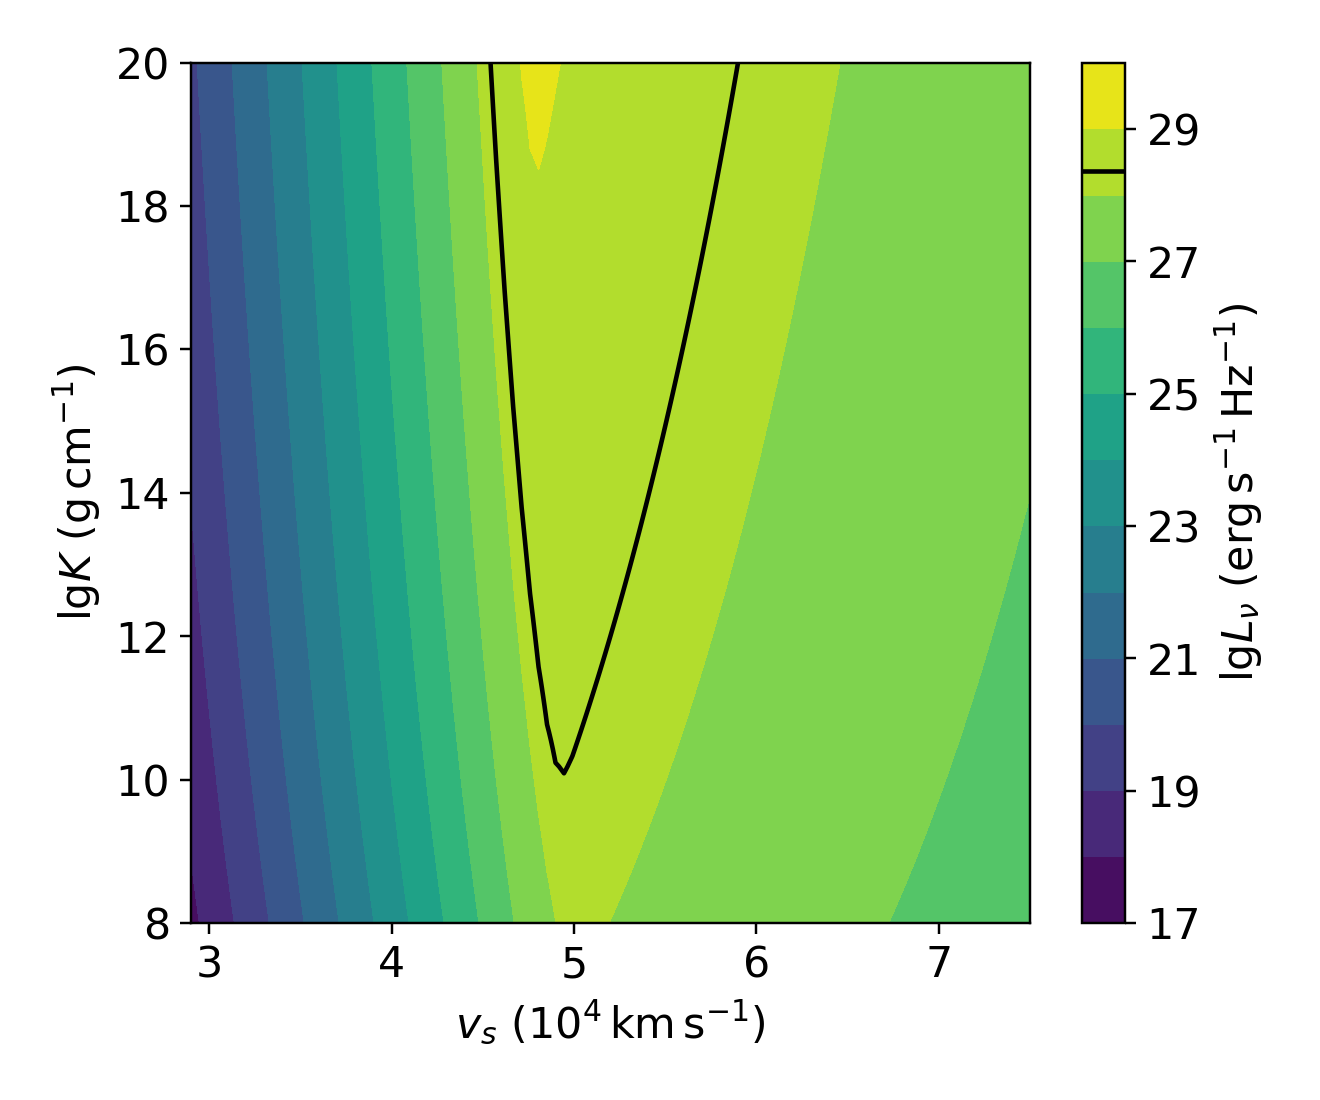

In [251]:
fig = plt.figure(figsize = (6, 5))
ax = plt.subplot(111)
# cp = ax.contourf(X, Y, lgLnus1_s2, 20, origin = "lower")
cp = ax.contourf(X, Y, lgLnus1_s2, [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
                 origin = "lower")
cp2 = ax.contour(X, Y, lgLnus1_s2, levels=[lgLnu1], colors='k', origin = "lower")
ax.set_xlim(vs_kms[0]/1e+4, vs_kms[-1]/1e+4)
ax.set_ylim(lgKs[0], lgKs[-1])
ax.set_xlabel('$v_s$ ('+r"$10^4\,\rm km\, s^{-1}$"+')')
ax.set_ylabel('lg$K$ ('+r"$\rm g\, cm^{-1}$"+")")
# fig.colorbar(cp) # Add a colorbar to a plot
cbar = fig.colorbar(cp)
cbar.ax.set_ylabel("lg"+r"$L_\nu$"+" ("+r"$\rm erg\, s^{-1}\, Hz^{-1}$"+")")
cbar.add_lines(cp2)
#ax.set_title("Constraint with upper limit at 230GHz", fontsize = fs)
#ax.text(5.1, 19, "ruled out")
plt.tight_layout()
plt.savefig("../paper/figures/radio_230GHz_s2.pdf")

<IPython.core.display.Javascript object>


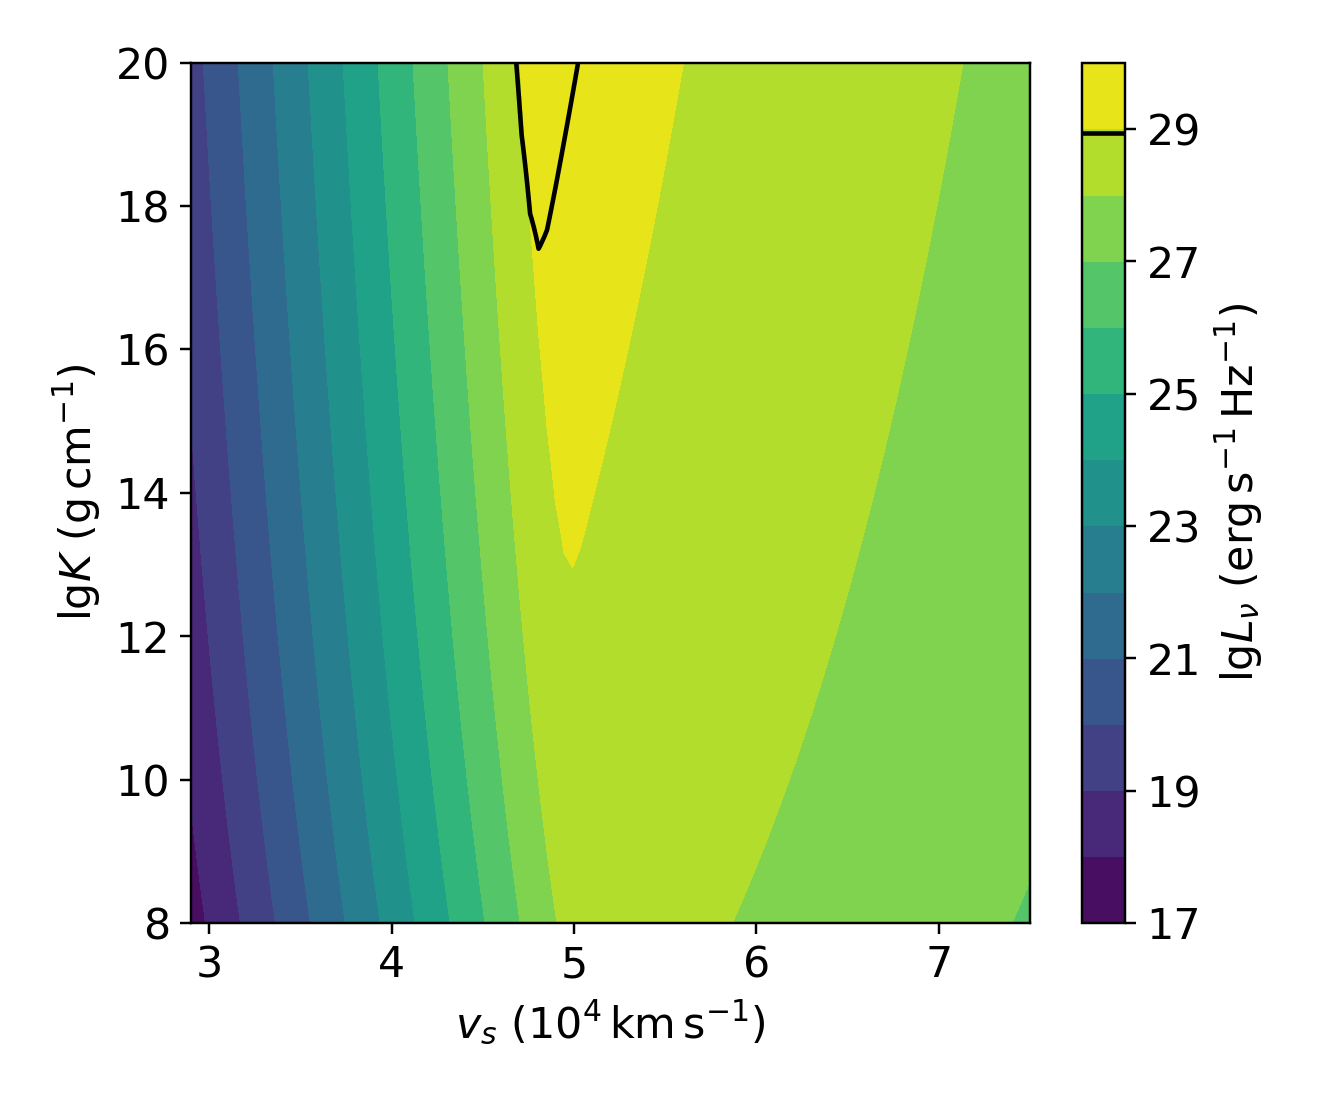

In [252]:
fig = plt.figure(figsize = (6, 5))
ax = plt.subplot(111)
# cp = ax.contourf(X, Y, lgLnus1_s2, 20, origin = "lower")
cp = ax.contourf(X, Y, lgLnus2_s2, [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
                 origin = "lower")
cp2 = ax.contour(X, Y, lgLnus1_s2, levels=[lgLnu2], colors='k', origin = "lower")
ax.set_xlim(vs_kms[0]/1e+4, vs_kms[-1]/1e+4)
ax.set_ylim(lgKs[0], lgKs[-1])
ax.set_xlabel('$v_s$ ('+r"$10^4\,\rm km\, s^{-1}$"+')')
ax.set_ylabel('lg$K$ ('+r"$\rm g\, cm^{-1}$"+")")
# fig.colorbar(cp) # Add a colorbar to a plot
cbar = fig.colorbar(cp)
cbar.ax.set_ylabel("lg"+r"$L_\nu$"+" ("+r"$\rm erg\, s^{-1}\, Hz^{-1}$"+")")
cbar.add_lines(cp2)
#ax.set_title("Constraint with upper limit at 345GHz", fontsize = fs)
plt.tight_layout()
#plt.savefig("../paper/figures/radio_230GHz_s2.pdf")

Constraints in the case of a constant-density profile

In [244]:
vs_kms = np.linspace(2.9e+4, 7.5e+4, 100)
n0s = np.logspace(2, 7, 100)
Lnus1_s0 = np.zeros((len(vs_kms), len(n0s)))
Lnus2_s0 = np.zeros((len(vs_kms), len(n0s)))
for i in range(len(vs_kms)):
    for j in range(len(n0s)):
        vs_km = vs_kms[i]
        n0 = n0s[j]
        fnu1 = ssa_light_curve(t_day = t_obs, nu = nu1, vs_km = vs_km, s=0, n0 = n0, D_cm = 10 * const.pc.cgs.value)
        fnu2 = ssa_light_curve(t_day = t_obs, nu = nu2, vs_km = vs_km, s=0, n0 = n0, D_cm = 10 * const.pc.cgs.value)
        Lnus1_s0[i][j] = fnu1 * 4 * np.pi * (10 * const.pc.cgs.value)**2
        Lnus2_s0[i][j] = fnu2 * 4 * np.pi * (10 * const.pc.cgs.value)**2

In [245]:
lgn0s = np.log10(n0s)
X, Y = np.meshgrid(vs_kms/1e+4, lgn0s)
lgLnus1_s0 = np.log10(Lnus1_s0)
lgLnus2_s0 = np.log10(Lnus2_s0)

<IPython.core.display.Javascript object>


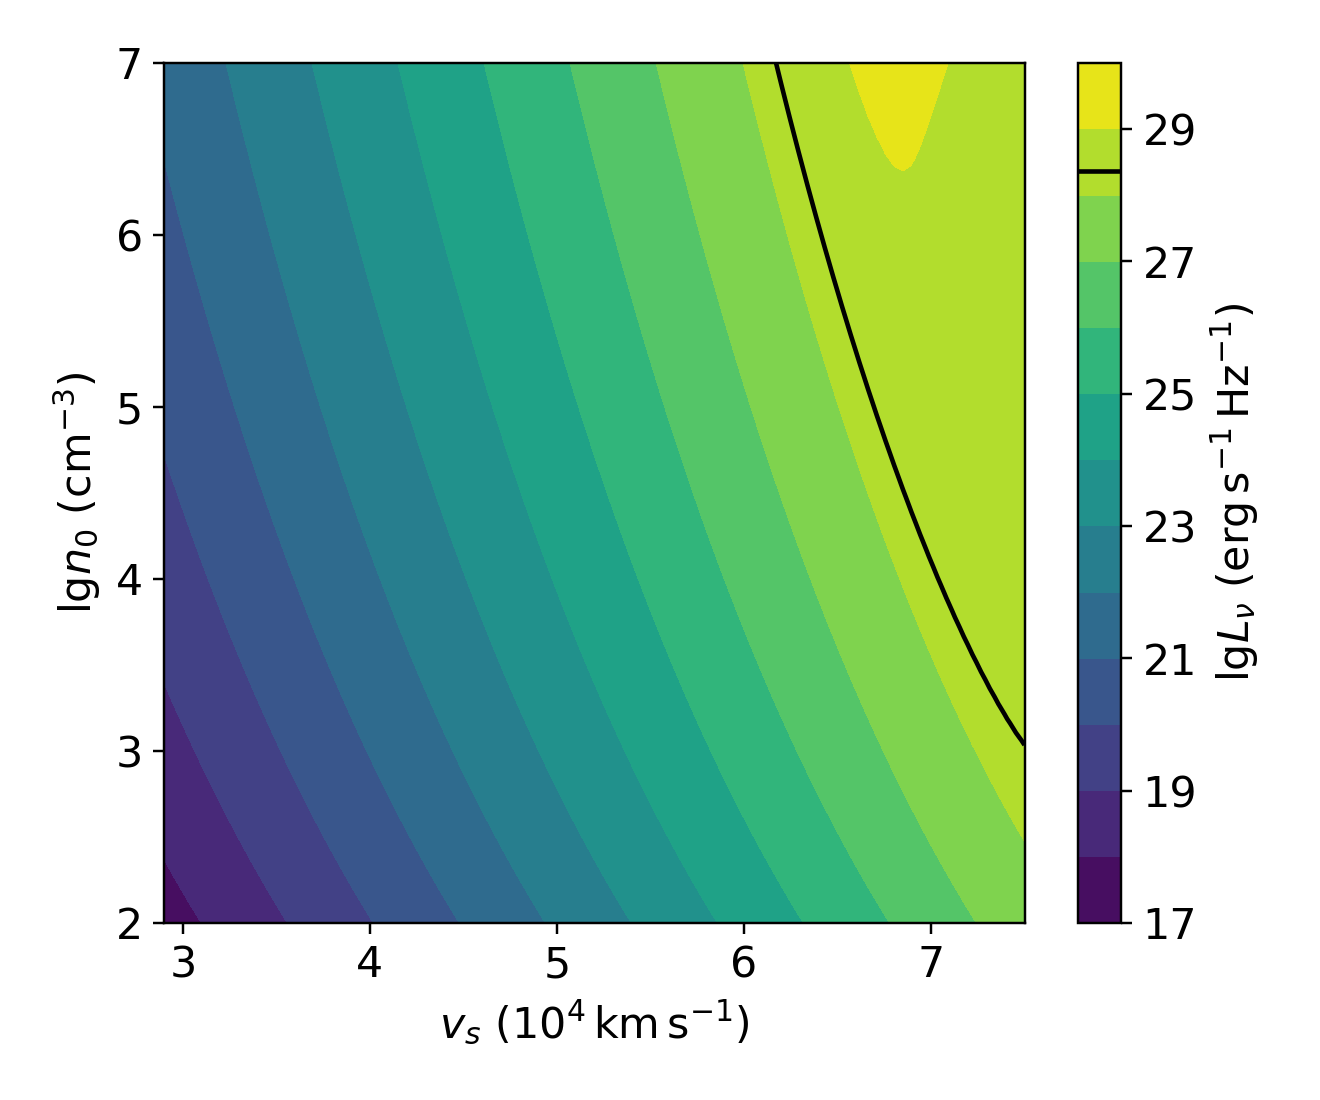

In [248]:
fig = plt.figure(figsize = (6, 5))
ax = plt.subplot(111)
# cp = ax.contourf(X, Y, lgLnus1_s2, 20, origin = "lower")
cp = ax.contourf(X, Y, lgLnus1_s0, [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
                 origin = "lower")
cp2 = ax.contour(X, Y, lgLnus1_s0, levels=[lgLnu1], colors='k', origin = "lower")
ax.set_xlim(vs_kms[0]/1e+4, vs_kms[-1]/1e+4)
ax.set_ylim(lgn0s[0], lgn0s[-1])
ax.set_xlabel('$v_s$ ('+r"$10^4\,\rm km\, s^{-1}$"+')')
ax.set_ylabel('lg$n_0$ ('+r"$\rm cm^{-3}$"+")")
# fig.colorbar(cp) # Add a colorbar to a plot
cbar = fig.colorbar(cp)
cbar.ax.set_ylabel("lg"+r"$L_\nu$"+" ("+r"$\rm erg\, s^{-1}\, Hz^{-1}$"+")")
cbar.add_lines(cp2)
#ax.set_title("Constraint with upper limit at 230GHz", fontsize = fs)
plt.tight_layout()
plt.savefig("../paper/figures/radio_230GHz_s0.pdf")

<IPython.core.display.Javascript object>


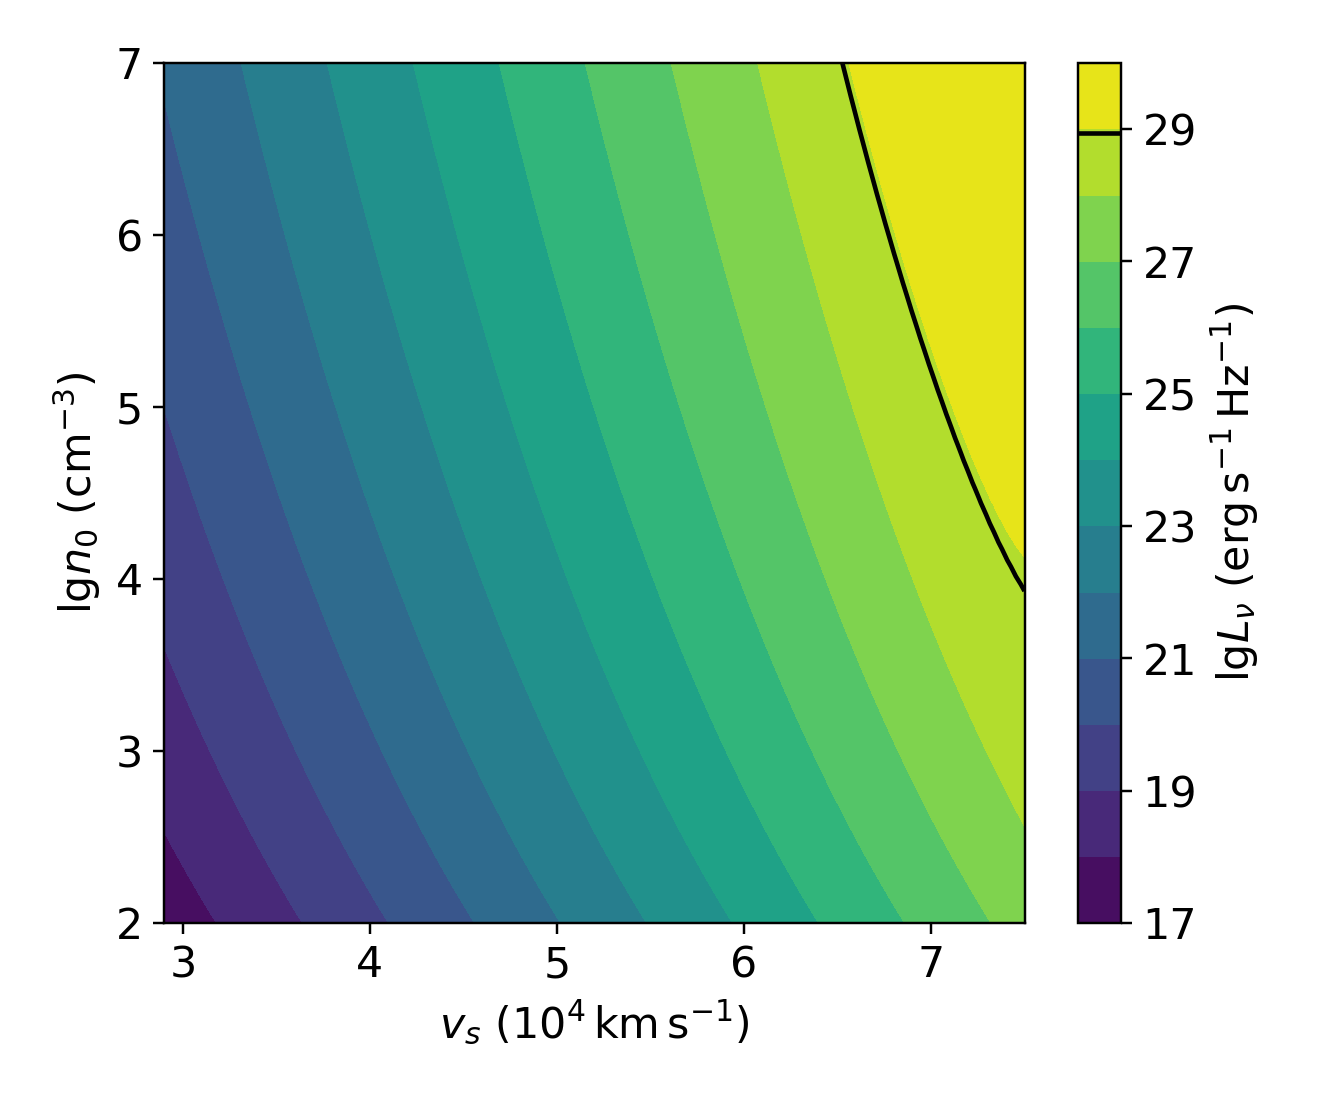

In [249]:
fig = plt.figure(figsize = (6, 5))
ax = plt.subplot(111)
# cp = ax.contourf(X, Y, lgLnus1_s2, 20, origin = "lower")
cp = ax.contourf(X, Y, lgLnus2_s0, [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
                 origin = "lower")
cp2 = ax.contour(X, Y, lgLnus2_s0, levels=[lgLnu2], colors='k', origin = "lower")
ax.set_xlim(vs_kms[0]/1e+4, vs_kms[-1]/1e+4)
ax.set_ylim(lgn0s[0], lgn0s[-1])
ax.set_xlabel('$v_s$ ('+r"$10^4\,\rm km\, s^{-1}$"+')')
ax.set_ylabel('lg$n_0$ ('+r"$\rm cm^{-3}$"+")")
# fig.colorbar(cp) # Add a colorbar to a plot
cbar = fig.colorbar(cp)
cbar.ax.set_ylabel("lg"+r"$L_\nu$"+" ("+r"$\rm erg\, s^{-1}\, Hz^{-1}$"+")")
cbar.add_lines(cp2)
#ax.set_title("Constraint with upper limit at 345GHz", fontsize = fs)
plt.tight_layout()
plt.savefig("../paper/figures/radio_345GHz_s0.pdf")

In [164]:
# in the case of s=2
nus = np.linspace(50, 600, 200) * 1e+9
fnus = ssa_light_curve(t_day = t_obs, nu = nus, vs_km = 4e+4, s=2, K = 7e+14, D_cm = 10 * const.pc.cgs.value)
Lnus = fnus * 4 * np.pi * (10 * const.pc.cgs.value)**2
fnus_ = ssa_light_curve(t_day = t_obs, nu = nus, vs_km = 4e+4, s=0, n0 = 3e+7, D_cm = 10 * const.pc.cgs.value)
Lnus_ = fnus_ * 4 * np.pi * (10 * const.pc.cgs.value)**2

<IPython.core.display.Javascript object>


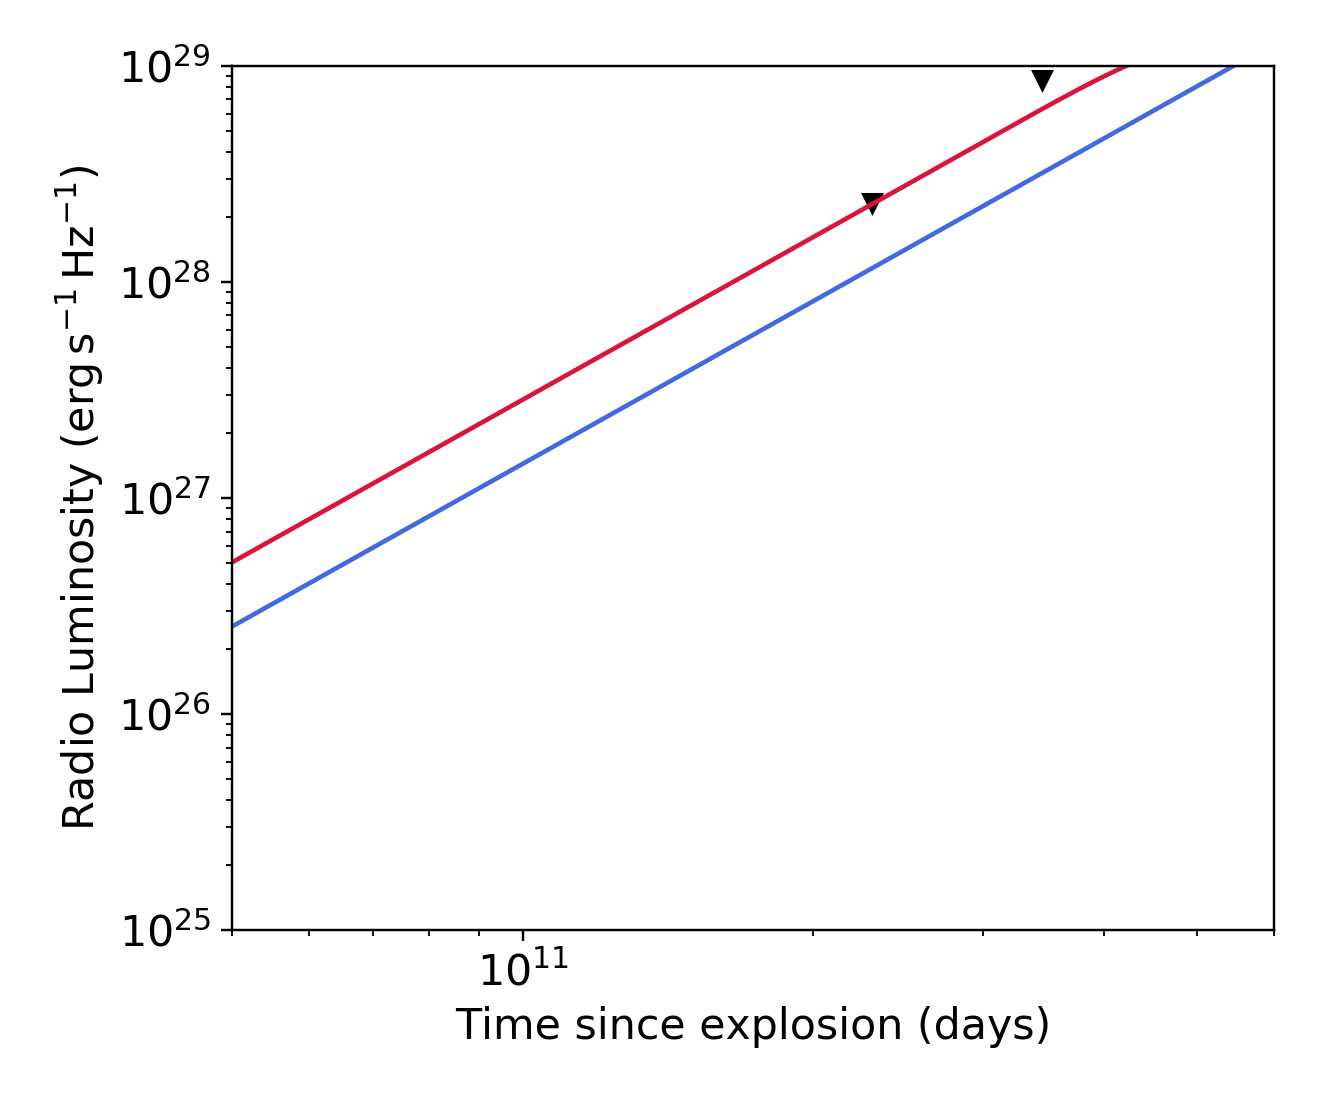

In [165]:
plt.figure(figsize = (6, 5))
plt.plot(nu1, Lnu1, 'v', color = "k")
plt.plot(nu2, Lnu2, 'v', color = "k")
plt.plot(nus, Lnus, color = "royalblue")
plt.plot(nus, Lnus_, color = "crimson")
plt.semilogx()
plt.semilogy()
plt.xlim(50e+9, 600e+9)
plt.ylim(1e+25, 1e+29)
plt.xlabel("Time since explosion (days)")
plt.ylabel("Radio Luminosity ("+r"$\rm erg\, s^{-1}\, Hz^{-1}$"+")")
plt.tight_layout()